In [36]:
import torch
from torch import nn
# Print torch version
print(torch.__version__)

2.3.0.post301


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
device

device(type='cuda')

In [38]:
# Load SMILES data
smiles = open('data/1to6.dmu.smi','r').read().splitlines()
smiles
print(len(smiles))
max_len = max(len(w) for w in smiles)
print(max_len)
print(smiles[:8])

35466
20
['C', 'N', 'O', 'C#C', 'C#N', 'N#N', 'C=C', 'C=N']


In [39]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(smiles))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '#', 2: '(', 3: ')', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '=', 10: 'C', 11: 'N', 12: 'O', 0: '.'}
13


In [40]:
# shuffle the smiles
import random
random.seed(42)
random.shuffle(smiles)

In [41]:
SEQ_LEN = 20
EMB_DIM = 20
LAT_DIM = 10
VOCAB_SIZE = 13

# build the dataset
def build_dataset(smiles):
    X = []
    for s in smiles:
        x = []
        for ch in s:
            ix = stoi[ch]
            x.append(ix)
        while len(x) < SEQ_LEN:
            x.append(0)
        X.append(x)
    X = torch.tensor(X)
    print(X.shape)
    return X
n1 = int(0.8 * len(smiles))
n2 = int(0.9 * len(smiles))
Xtr = build_dataset(smiles[:n1])
Xdev = build_dataset(smiles[n1:n2])
Xte = build_dataset(smiles[n2:])

torch.Size([28372, 20])
torch.Size([3547, 20])
torch.Size([3547, 20])


In [42]:
for x in Xtr[-20:]:
    print(''.join(itos[ix.item()] for ix in x), '-->', x.tolist())

CC1CC(=C)C1......... --> [10, 10, 4, 10, 10, 2, 9, 10, 3, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
C#CN1OCO1........... --> [10, 1, 10, 11, 4, 12, 10, 12, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
N=CC=CN=O........... --> [11, 9, 10, 10, 9, 10, 11, 9, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
N=C=C1ON=C1......... --> [11, 9, 10, 9, 10, 4, 12, 11, 9, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
O=C1NN=NO1.......... --> [12, 9, 10, 4, 11, 11, 9, 11, 12, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CCN(N)NN............ --> [10, 10, 11, 2, 11, 3, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
C1NN2ONC12.......... --> [10, 4, 11, 11, 5, 12, 11, 10, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ONC1=C(O)N1......... --> [12, 11, 10, 4, 9, 10, 2, 12, 3, 11, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
NN1C2NC12........... --> [11, 11, 4, 10, 5, 11, 10, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
NC(=O)N=C=N......... --> [11, 10, 2, 9, 12, 3, 11, 9, 10, 9, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CC#CNCN............. --> [10, 10, 1, 10, 11, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Create Variational Autoencoder model
class VAE_smiles_base(nn.Module):
    def __init__(self, seq_len = SEQ_LEN, vocab_size=13, emb_dim = EMB_DIM, hidden_dim=100, latent_dim=LAT_DIM):
        super().__init__()
    
        # ecoder    
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)  
        self.rnn_emb2hid = nn.GRU(emb_dim, hidden_dim, batch_first=True)   
        self.fc_hid2mean = nn.Linear(hidden_dim, latent_dim)   
        self.fc_hid2logvar = nn.Linear(hidden_dim, latent_dim)  
        
        # decoder
        self.fc_lat2hid = nn.Linear(latent_dim, hidden_dim)  
        self.rnn_hid2emb = nn.GRU(emb_dim, hidden_dim, batch_first=True)  
        self.fc_emb2out = nn.Linear(hidden_dim, vocab_size)   
    
    def encode(self, x):
        x = self.emb(x)   # (B,20,20)
        _, hn_e = self.rnn_emb2hid(x)  # (1, B, 200) 
        hn_e = hn_e.squeeze(0)  # (B, 200)
        mean = self.fc_hid2mean(hn_e)  #   (B,10)
        logvar = self.fc_hid2logvar(hn_e)  #  (B,10)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar)
        z = mean + logvar * epsilon
        return z
    
    def decode(self, z):  # (B, 10)
        hn_d = self.fc_lat2hid(z) # (B, 200)
        hn_d = hn_d.unsqueeze(0)  # (1, B, 200)
        h0 = torch.zeros(z.size(0), SEQ_LEN, EMB_DIM).to(device)  # (B, 20, 20)
        z, _ = self.rnn_hid2emb(h0, hn_d) # (B, 20, 20) 
        x = self.fc_emb2out(z) # (B, 20, 13)
        return x
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar   

# Loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.cross_entropy(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD                

In [43]:
# Improved Variational Autoencoder model for SMILES generation
class VAE_smiles(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, hidden_dim=100, latent_dim=LAT_DIM):
        super().__init__()

        # Encoder
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn_emb2hid = nn.GRU(emb_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2, bidirectional=True)
        self.fc_hid2mean = nn.Linear(hidden_dim * 2 * 2, latent_dim)  # Multiply by 2 due to bidirection, 2 again due to num_layers
        self.fc_hid2logvar = nn.Linear(hidden_dim * 2 * 2, latent_dim)
        
        # Decoder
        self.fc_lat2hid = nn.Linear(latent_dim, hidden_dim * 2)  # Adjusted for num_layers
        self.rnn_hid2emb = nn.GRU(emb_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2)
        self.fc_emb2out = nn.Linear(hidden_dim, vocab_size)
    
    def encode(self, x):
        x = self.emb(x)  # (batch_size, seq_len, emb_dim)
        _, hn_e = self.rnn_emb2hid(x)  # (num_layers * num_directions, batch, hidden_size)
        hn_e = hn_e.view(hn_e.size(1), -1)  # (batch, hidden_size * num_directions * num_layers) 
        mean = self.fc_hid2mean(hn_e) # (batch, latent_dim)
        logvar = self.fc_hid2logvar(hn_e) # (batch, latent_dim)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar)
        z = mean + torch.exp(0.5 * logvar) * epsilon  # Adjusted to ensure logvar is non-negative
        return z
    
    def decode(self, z):
        hn_d = self.fc_lat2hid(z)  # (batch, hidden_size * num_layers)
        hn_d = hn_d.view(2, z.size(0), -1)  
        h0 = torch.zeros(z.size(0), SEQ_LEN, EMB_DIM).to(device)
        z, _ = self.rnn_hid2emb(h0, hn_d)
        x_hat = self.fc_emb2out(z)
        return x_hat
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

# Improved Loss function with KLD annealing
def loss_function(x, x_hat, mean, log_var, beta=1.0):
    reproduction_loss = nn.functional.cross_entropy(x_hat, x, reduction='sum') / x.size(0)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0)
    return reproduction_loss + beta * KLD

In [44]:
batch_size = 64
Xb = torch.randint(0,vocab_size,(batch_size,SEQ_LEN)).to(device)
print(Xb.shape, Xb.view(-1).shape)
model = VAE_smiles(seq_len=SEQ_LEN).to(device)
x, _, _ = model(Xb)
total_params = sum(p.numel() for p in model.parameters())
print(x.shape, x.view(-1, VOCAB_SIZE).shape, total_params)

torch.Size([64, 20]) torch.Size([1280])
torch.Size([64, 20, 13]) torch.Size([1280, 13]) 363393


In [45]:
model = VAE_smiles().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
epochs = 210000
batch_size = 64
lossi = []
for epoch in range(epochs):
    # Sample batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[idx].to(device)
    
    # Train the model
    model.train()
    optimizer.zero_grad()
    x_hat, mean, log_var = model(Xb)
    loss = loss_function(Xb.view(-1), x_hat.view(-1, vocab_size), mean, log_var)
    lossi.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 10000 == 0:
        print("\tEpoch", epoch, "\tLoss: ", loss.item())
    
    modelName = 'VAE_smiles'
    if epoch % 50000 == 0 and epoch > 0:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'iteration': epoch
        }
        torch.save(checkpoint, f'models/{modelName}_checkpoint_{epoch}.pt')
        print(f'Checkpoint saved at iteration {epoch}')
    if epoch > 100000:
        lr = 1e-4
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


	Epoch 0 	Loss:  2.5631418228149414
	Epoch 10000 	Loss:  1.069005012512207
	Epoch 20000 	Loss:  1.0599697828292847
	Epoch 30000 	Loss:  1.0610876083374023
	Epoch 40000 	Loss:  1.0461186170578003
	Epoch 50000 	Loss:  1.0627928972244263
Checkpoint saved at iteration 50000
	Epoch 60000 	Loss:  1.0439836978912354
	Epoch 70000 	Loss:  1.004823923110962
	Epoch 80000 	Loss:  1.021720290184021
	Epoch 90000 	Loss:  1.0383946895599365
	Epoch 100000 	Loss:  1.0738816261291504
Checkpoint saved at iteration 100000
	Epoch 110000 	Loss:  1.1380194425582886
	Epoch 120000 	Loss:  1.0413950681686401
	Epoch 130000 	Loss:  1.0844570398330688
	Epoch 140000 	Loss:  1.0710018873214722
	Epoch 150000 	Loss:  1.055495023727417
Checkpoint saved at iteration 150000
	Epoch 160000 	Loss:  1.091432809829712
	Epoch 170000 	Loss:  1.0339361429214478
	Epoch 180000 	Loss:  1.1104644536972046
	Epoch 190000 	Loss:  1.0620075464248657
	Epoch 200000 	Loss:  1.0497492551803589
Checkpoint saved at iteration 200000


In [63]:
from rdkit import Chem
model = VAE_smiles().to(device)
checkpoint = torch.load('models/VAE_smiles_checkpoint_200000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
latent_dim = LAT_DIM
def generate_smiles(z):
    z_sample = torch.tensor([z], dtype=torch.float).to(device)
    logits = model.decode(z_sample)
    logits = logits.view(-1, vocab_size)
    prob = nn.functional.softmax(logits, dim=1)
    #indices = torch.argmax(prob, dim=-1)
    indices = torch.multinomial(prob, num_samples=1).squeeze(-1)
    #print(indices)
    return ''.join(itos[ix.item()] for ix in indices).replace('.','')
    #return indices
samp = torch.randn(latent_dim)
#samp = torch.tensor([0,0])
print(samp)
gen_smiles = generate_smiles(samp.tolist())
print(gen_smiles, Chem.MolToSmiles(Chem.MolFromSmiles(gen_smiles)))

tensor([ 0.1472, -1.0828, -0.0775,  1.2894,  0.8551, -0.4872,  0.9012,  0.4929,
        -0.9146, -0.4446])


[10:51:52] SMILES Parse Error: extra open parentheses for input: 'OCC(CO=C=1'


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)

In [68]:
# Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

uniqueList = []
validCount = 0
for i in range(10000):
    samp = torch.rand(LAT_DIM)
    smi = generate_smiles(samp.tolist())
    if Chem.MolFromSmiles(smi):
        validCount+=1
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        if canon_smi not in uniqueList:
            uniqueList.append(canon_smi)

print(f'Valid SMILES: {validCount}/10000')
print(f'Unique SMILES: {len(uniqueList)}/{validCount}')

Valid SMILES: 403/10000
Unique SMILES: 402/403


In [67]:
print(uniqueList)

['C1CCCNNCC1', 'O=COCNNCO', 'CN=C1CC1NC', 'C=C=CC=NCN', 'NCCCNO', 'OC1CC=NNON1', 'NC1NCC1CO', 'CCCN1CC=N1', 'CCCC1C=CO1', 'CNNNN=CCNN', 'CC1NNCON1O', 'C1Nn2on2N1', 'CNC1NC1C=O', 'CCNNC=NCNN', 'CNCOCNCCCO', 'NOCCCONCNO', 'NNCNOCCO', 'NNNCCOCCO', 'CCC=NNNNC', 'CONNCOCNO', 'NOC1CNCO1', 'CCCCN=CNCN', 'NCC=CNNO', 'CC1NCCNCN1', 'CNN=C=CNN', 'Cc1co[nH]1', 'C=CN1CCN1', 'C=NCCCNNCC', 'CCN1C=CC1', 'C=CN=CCCCC', 'C1NC2(CN2)NO1', 'ONN=CC1=CC1', 'CNC=CCCNCN', 'NOC1CCCC1N', 'CC1CCNC1CO', 'C1CN2NNC2N1', 'CC1=C(ON)CCC1', 'NCCCCCCCCO', 'CCNN=NNN', 'O=NNNNNCNO', 'CNNCC=NC=O', 'C1=NNCCC1', 'CC1N=CC1CO', 'CN=CNCCNO', 'CCN1COC1', 'CCN(C)NNC', 'NC=CNNCNN', 'OCNNOOCO', 'CCNCNC=CCO', 'C=C=CCCCN', 'C1=CONN=C1', 'CCC=NCCC', 'CC1=NCONN1', 'NOC1=CCNC1', 'C=NC1=COC1', 'CCCCCONN=N', 'NC1CNNO1', 'C=NCCCCC', 'OCCNCC1CCC1', 'C1=CNNNNOC1', 'NCNCNCNNNN', 'CN1CCCNCC1', 'C#CNNNC=NC', 'OCCCCNC1NON1', 'NCC1CCCNC1', 'CCONC=NO', 'NCCN=CNNOO', 'CCCNNCCCNCN', 'CCN1NC1CO', 'CNCNC1=CC1', 'CN1CCCN1CN', 'CNC=CCOC', 'ON1NCONN1', 'CC

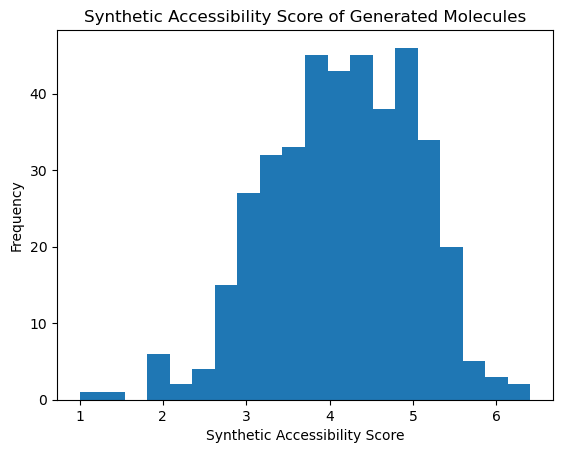

In [70]:
# Compute synthetic accessibility score 
import sys, os
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score.sascorer import calculateScore
sasList = [calculateScore(Chem.MolFromSmiles(s)) for s in uniqueList]
plt.hist(sasList, bins=20)
plt.xlabel('Synthetic Accessibility Score')
plt.ylabel('Frequency')
plt.title('Synthetic Accessibility Score of Generated Molecules')
plt.show()

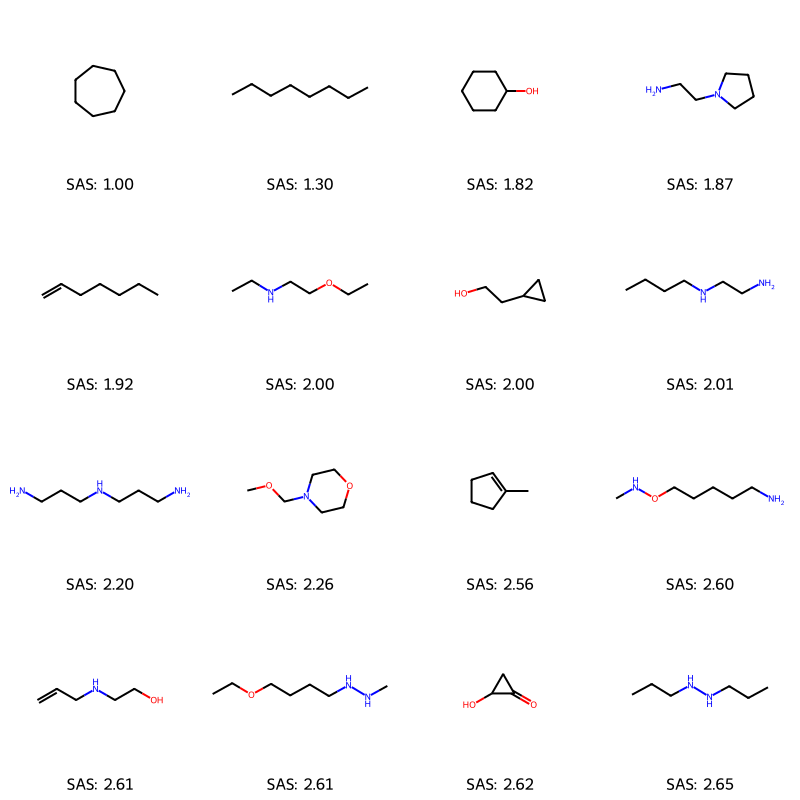

In [71]:
# Sort the generated molecules by synthetic accessibility score
from rdkit.Chem import Draw
sortedList = [s for _,s in sorted(zip(sasList,uniqueList), reverse=False)]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[:16]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[:16]])

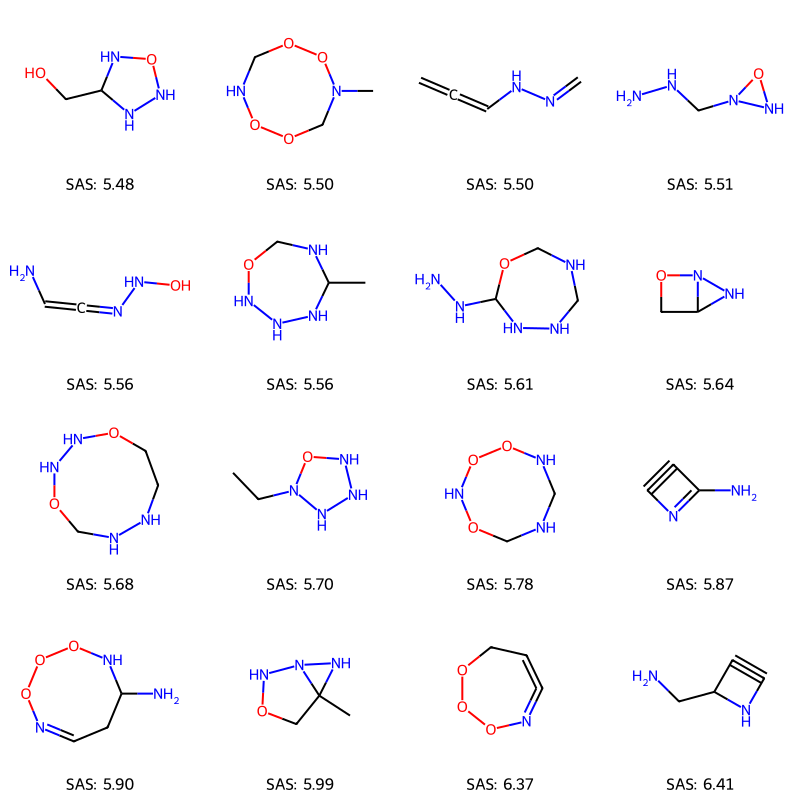

In [72]:
# Draw the molecules with the highest synthetic accessibility score
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in sortedList[-16:]], molsPerRow=4, subImgSize=(200,200), legends=[f'SAS: {calculateScore(Chem.MolFromSmiles(s)):.2f}' for s in sortedList[-16:]])